## Ejercicio 7

Mozilla Common Voice es un proyecto (https://commonvoice.mozilla.org/es/datasets) que desarrolla una base de datos de voces, abierta y multi idioma, que cualquiera puede usar para entrenar aplicaciones que utilicen la voz como interfaz.

En particular cuenta con un pequeño corpus denominado **Single Word** que contiene las palabras habladas SI, NO, Hey, Firefox y dígitos del cero al nueve.


<div style="text-align: center;">
    <img src='../../images/p5-ej7.png' width="60%">
</div>

### a)

Utilizando los ejemplos de una versión seleccionada de estos audios en el Moodle del curso,
transformarlos en imágenes para que puedan ser procesados por la red siguiendo los siguientes
criterios:
- Eliminar los silencios iniciales y finales. La comparación de los silencios en 2 audios produce una falsa coincidencia.
- Elegir un tamaño fijo para los audios. Todas las imágenes deben tener el mismo tamaño. Como las palabras del corpus son breves un tamaño de 0.75 segundos es razonable.
- Achicar/agrandar los audios manteniendo el tono de la voz
- Pasar el audio del dominio del tiempo al domino de la frecuencia. Dividir el audio en pequeños intervalos y obtener un conjunto de valores que determinen las frecuencias presentes. Para esto puede utilizarse la transformada de Fourier (FFT) o los coeficientes cepstrales en frecuencia mel (MFCC) que aproximan la sensibilidad del oído humano.
- Finalmente convertir los coeficientes en una imagen con compresión sin pérdida como PNG.

In [1]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive
DATOS_DIR = '../../Datos'
zip_path = os.path.join(DATOS_DIR, 'Voz-Palabras.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = DATOS_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ../../Datos


In [5]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense, Input, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import skimage.io as io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob

def import_data(img_list):
    img_data = []
    label_data = []

    img_count = len(img_list)
    for i in range(0,img_count):
        img = img_list[i]
        img_read = io.imread(img)

        img_read = img_read/img_read.max() # normaliza pixeles entre 0 y 1
        img_read = img_read.reshape((*img_read.shape,1))

        #img_read = img_read[:,:,0]         # extrae 1er canal porque estan en escala de grises
        #img_read = img_read.flatten()      # redefine como arreglo de 1 dimension
        img_data.append(img_read)          # agrega a lista de imágenes a procesar
        label_data.append(img[img.rindex('_')+1:-4])         # extrae texto de la palabra desde el nombre del archivo
        # muestra progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes (%d): %6.2f%%" % (i,100*i/img_count), end="")
    print("\rCargando imágenes (%d): 100.00%%\n" % i)

    return np.array(img_data), np.array(label_data)


IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

# %% Carga imágenes de entrenamiento y testeo desde las carpetas

# lista de archivos para entrenamiento
DATOS_DIR = '../../Datos/'
train_img_list = glob.glob(DATOS_DIR + 'Voz/Espectros/Train/*.png')
assert len(train_img_list) > 0, IMG_ERROR

# carga las imagenes a partir de los nombres de archivos
xtrain, yraw = import_data(train_img_list)

# %% Establece parámetros de entrenamiento

# tamano de imagen extraido de los datos
IMG_SIZE = (xtrain.shape[1], xtrain.shape[2],1)


# cantidad de pasadas de los datos
EPOCAS = 200
# cantidad de datos a procesar para actualizar pesos
LOTES  = 300

# %% binariza valores del target

# conviertes el id de la clase en "one hot encoding": clase 3 => [0,0,0,1,0,0]
# Binarizador para convertir el nombre de la clase en one hot encoding
binarizador = preprocessing.LabelBinarizer()
ytrain= binarizador.fit_transform(yraw)


# cantidad de clases
# N_CLASSES = len(np.unique(yraw))
CLASES  = binarizador.classes_

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.10, shuffle=True)

Cargando imágenes (10281): 100.00%



### b)

Utilizando las imágenes generadas en a), entrenar un modelo de red neuronal convolucional que permita reconocer las palabras del corpus Single Word

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(img_size, classes):
    model = Sequential()

    # La forma de entrada debe ser (height, width, channels)
    model.add(Input(shape=img_size))  # img_size ya debe incluir los canales (ej: (96, 96, 3))

    # Bloque 1: CONV => LeakyReLU => BN => POOL
    model.add(Conv2D(16, (5, 5), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 2
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 3
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 4
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 5
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Capas Fully Connected
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))

    return model

# Verifica la forma de IMG_SIZE y CLASES antes de construir el modelo
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Número de clases: {len(CLASES)}")

# Obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, len(CLASES))
model.summary()

# Compilación
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Tamaño de imagen: (64, 65, 1)
Número de clases: 14


2025-10-21 10:10:43.382267: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/gblas/Developer/deep-learning-unlp/env/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 65, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 79,246 (309.55 KB)

 Trainable params: 78,830 (307.93 KB)

 Non-trainable params: 416 (1.62 KB)

#### Entrenamiento

In [7]:
# %% Entrena el modelo

es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# entrena el modelo y guarda la historira del progreso
H=model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS,
          validation_data = (x_val, y_val), callbacks=[es])


Epoch 1/200


E0000 00:00:1761052250.566283  149823 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_1/leaky_re_lu_1_2/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_1/conv2d_1_2/BiasAdd'.


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - accuracy: 0.4330 - loss: 1.7957 - val_accuracy: 0.0748 - val_loss: 2.6375
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.7322 - loss: 0.9057 - val_accuracy: 0.0748 - val_loss: 2.6599
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.8202 - loss: 0.6074 - val_accuracy: 0.0748 - val_loss: 2.7196
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.8703 - loss: 0.4475 - val_accuracy: 0.0904 - val_loss: 2.7907
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.8968 - loss: 0.3443 - val_accuracy: 0.0845 - val_loss: 2.9973
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9197 - loss: 0.2747 - val_accuracy: 0.0768 - val_loss: 3.0990
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.9356 - loss: 0.2289 - val_accuracy: 0.1963 - val_loss: 2.7662
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 370ms/step - accuracy: 0.9395 - loss: 0.1977 - val_accuracy

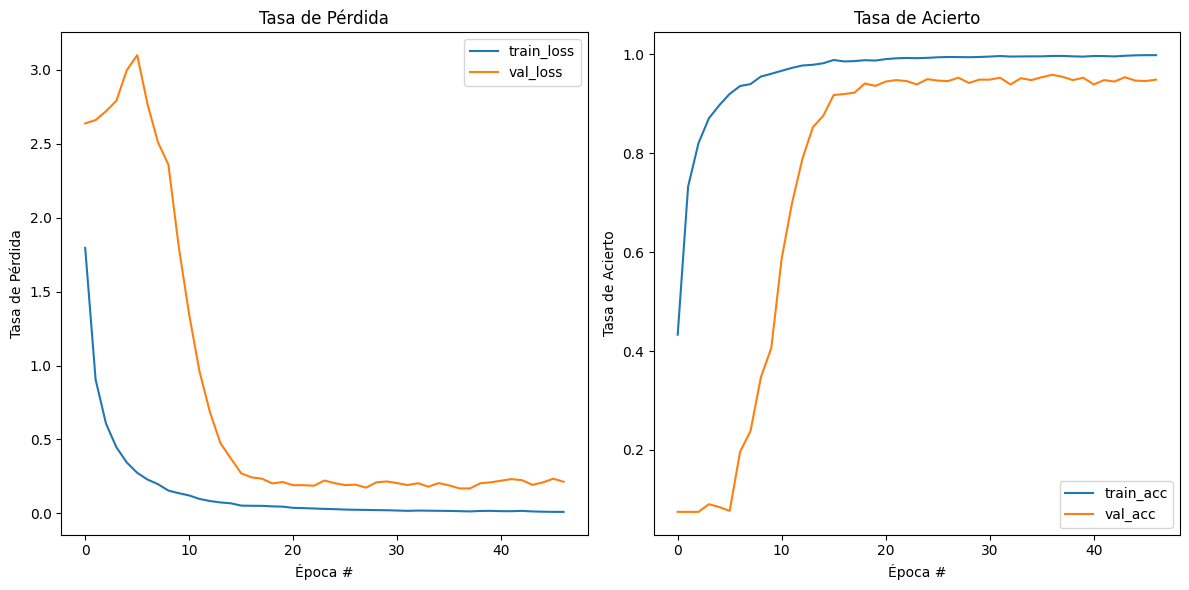

In [8]:
# Crea una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: Tasa de pérdida (Loss)
ax1.plot(H.history["loss"], label="train_loss")
ax1.plot(H.history["val_loss"], label="val_loss")
ax1.set_title("Tasa de Pérdida")
ax1.set_xlabel("Época #")
ax1.set_ylabel("Tasa de Pérdida")
ax1.legend(loc="upper right")

# Gráfico 2: Tasa de acierto (Accuracy)
ax2.plot(H.history["accuracy"], label="train_acc")
ax2.plot(H.history["val_accuracy"], label="val_acc")
ax2.set_title("Tasa de Acierto")
ax2.set_xlabel("Época #")
ax2.set_ylabel("Tasa de Acierto")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

Cargando imágenes (6348): 100.00%

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

        CERO       1.00      1.00      1.00       647
       CINCO       1.00      1.00      1.00       672
      CUATRO       1.00      1.00      1.00       668
         DOS       1.00      1.00      1.00       662
     FIREFOX       1.00      1.00      1.00       562
         HEY       1.00      1.00      1.00       632
          NO       1.00      1.00      1.00       671
       NUEVE       1.00      1.00      1.00       648
        OCHO       1.00      1.00      1.00       678
        SEIS       1.00      1.00      1.00       664
          SI       1.00      1.00      1.00       703
       SIETE       1.00      1.00      1.00       683
        TRES       1.00      1.00      1.00       691
         UNO       1.00      1.00      1.00       672

    accuracy                           1.00      9253
   macro avg     

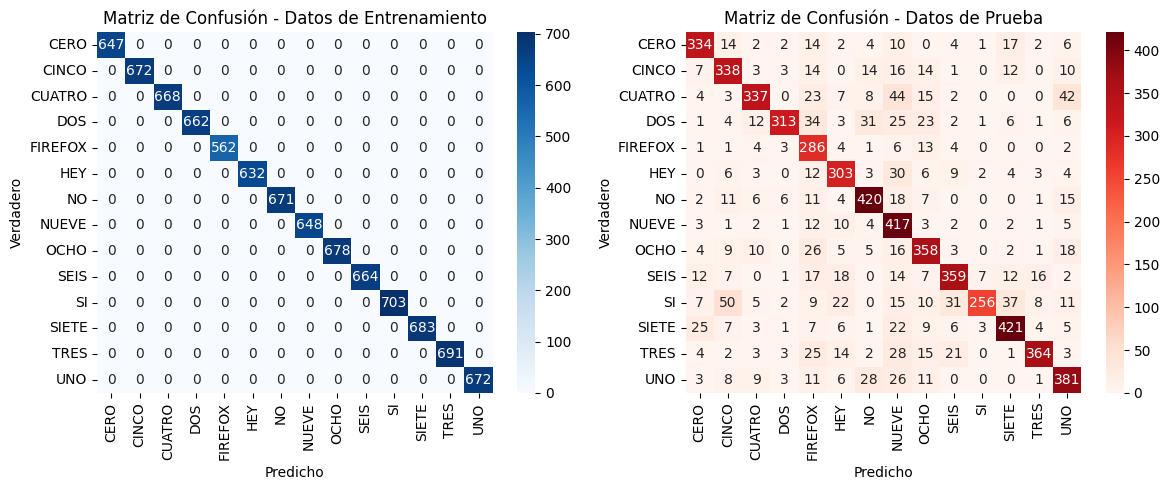

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

def evaluar(x_data, y_data, bin_tr):
    y_pred = model.predict(x_data)
    y_pred_lbl = bin_tr.inverse_transform(y_pred)
    y_data_lbl = bin_tr.inverse_transform(y_data)
    conf_mt = confusion_matrix(y_data_lbl, y_pred_lbl)
    acc = (y_pred_lbl == y_data_lbl).sum()/len(y_data_lbl)
    report = classification_report(y_data_lbl, y_pred_lbl)
    return (acc, conf_mt, report)

# Verificación con datos de testeo
LOCAL_DIR = '../../Datos/Voz/'
img_list = glob.glob(LOCAL_DIR + 'Espectros/Test/*.png')
assert len(img_list) > 0, IMG_ERROR

# Carga las imágenes a partir de los nombres de archivos
x_test, y_raw = import_data(img_list)
y_test = binarizador.transform(y_raw)

# Evalua el modelo en datos de entrenamiento y datos de prueba
(acc_train, conf_mt_train, report_train) = evaluar(x_train, y_train, binarizador)
(acc_test, conf_mt_test, report_test) = evaluar(x_test, y_test, binarizador)

# Crear una figura con dos subgráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Matriz de confusión para datos de entrenamiento con Seaborn
sns.heatmap(conf_mt_train, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=CLASES, yticklabels=CLASES)
ax1.set_title('Matriz de Confusión - Datos de Entrenamiento')
ax1.set_xlabel('Predicho')
ax1.set_ylabel('Verdadero')
print(report_train)

# Gráfico 2: Matriz de confusión para datos de prueba con Seaborn
sns.heatmap(conf_mt_test, annot=True, fmt='d', cmap='Reds', ax=ax2, xticklabels=CLASES, yticklabels=CLASES)
ax2.set_title('Matriz de Confusión - Datos de Prueba')
ax2.set_xlabel('Predicho')
ax2.set_ylabel('Verdadero')
print(report_test)

plt.tight_layout()
plt.show()